# Task 5 — Decision Trees & Random Forests

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)


In [5]:
# Path to dataset
DATA_PATH = r'C:\Users\harsh\Downloads\heart_disease\heart.csv'  
RANDOM_STATE = 42
TEST_SIZE = 0.2


In [7]:
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please place the dataset file in the working directory or change DATA_PATH.")

df = pd.read_csv(DATA_PATH)
print('Dataset loaded: ', DATA_PATH)
print('Shape:', df.shape)

df.head()


Dataset loaded:  C:\Users\harsh\Downloads\heart_disease\heart.csv
Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
t

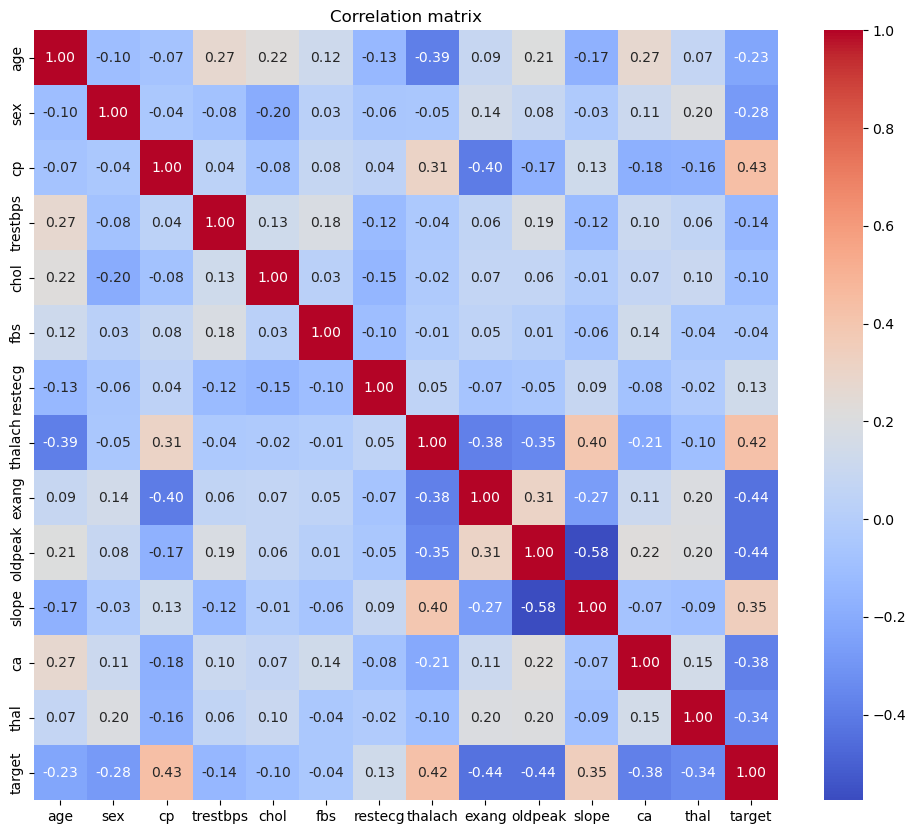

In [9]:
# Basic info
print(df.info())

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nStatistical summary:")
print(df.describe())

# Detect target column
POSSIBLE_TARGETS = ['target', 'Outcome', 'HeartDisease', 'heart_disease', 'diagnosis', 'has_disease']
target_col = None
for c in POSSIBLE_TARGETS:
    if c in df.columns:
        target_col = c
        break
if target_col is None:
    for c in df.columns:
        if df[c].nunique() == 2:
            target_col = c
            break
if target_col is None:
    target_col = df.columns[-1]
    print(f"Warning: couldn't auto-detect target; using last column '{target_col}'. Please verify.")
else:
    print(f"Detected target column: {target_col}")

print("\nTarget value counts:")
print(df[target_col].value_counts())

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [11]:
# Handle missing values
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    fraction_missing_rows = df.isnull().any(axis=1).mean()
    if fraction_missing_rows < 0.05:
        df = df.dropna()
        print('Dropped rows with missing values.')
    else:
        num_cols = df.select_dtypes(include=[np.number]).columns
        for c in num_cols:
            df[c] = df[c].fillna(df[c].median())
        print('Imputed numeric columns with median.')
else:
    print('No missing values.')

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    print('Applied one-hot encoding.')

# Split into features & target
X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)


No missing values.
X shape: (1025, 13)
y shape: (1025,)


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

Train shape: (820, 13)
Test shape : (205, 13)


Decision Tree baseline performance:
Accuracy: 0.9853658536585366
Precision: 1.0
Recall: 0.9714285714285714
F1: 0.9855072463768116
ROC AUC: 0.9857142857142858


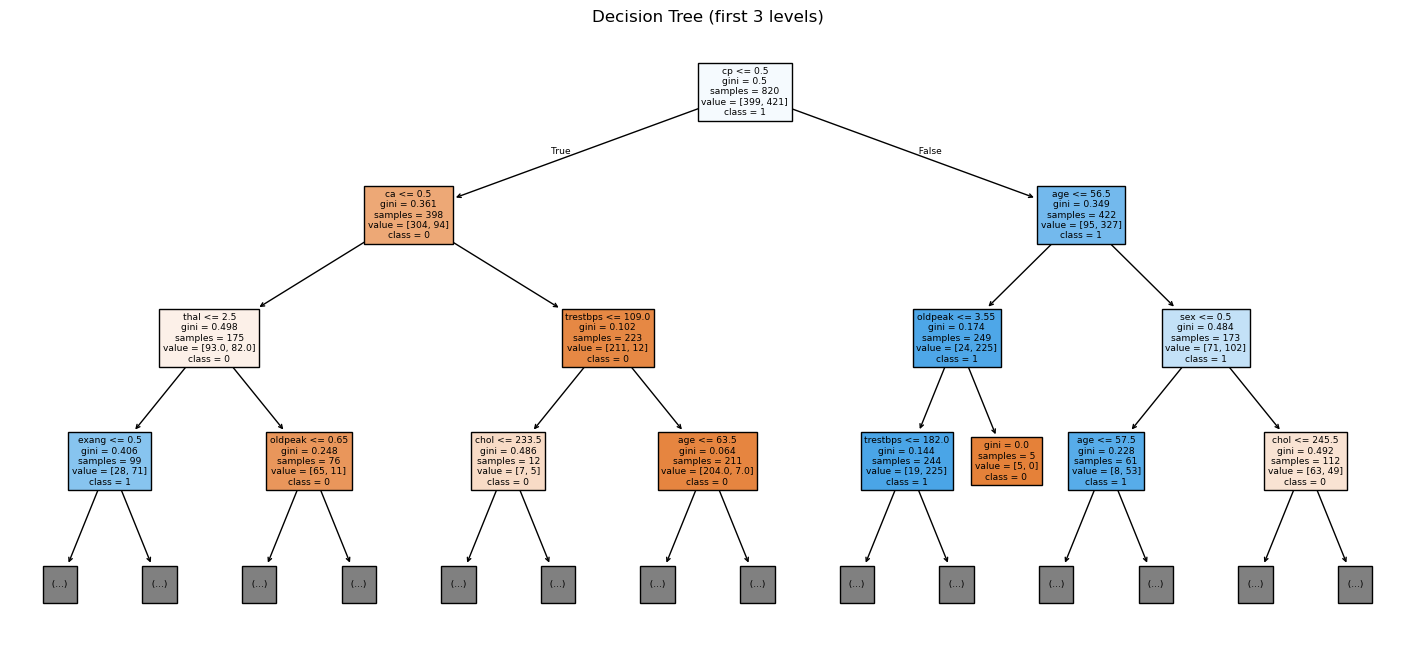

In [19]:
# Baseline Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print('Decision Tree baseline performance:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1:', f1_score(y_test, y_pred, zero_division=0))

# ROC AUC (if binary)
if len(np.unique(y)) == 2:
    y_proba = dt.predict_proba(X_test)[:, 1]
    print('ROC AUC:', roc_auc_score(y_test, y_proba))

# Visualize first 3 levels
plt.figure(figsize=(18, 8))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in sorted(y.unique())], filled=True, max_depth=3)
plt.title('Decision Tree (first 3 levels)')
plt.show()

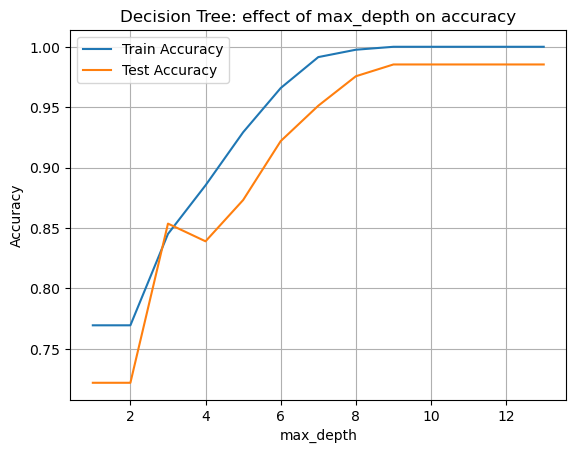

In [23]:
# Overfitting Analysis
max_depths = list(range(1, min(21, X.shape[1]+1)))
train_scores = []
test_scores = []

for d in max_depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot(max_depths, train_scores, label='Train Accuracy')
plt.plot(max_depths, test_scores, label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: effect of max_depth on accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Decision Tree Tuning (GridSearchCV)
param_grid_dt = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1
)

dt_grid.fit(X_train, y_train)
print('Best params for Decision Tree:', dt_grid.best_params_)
print('Best CV score:', dt_grid.best_score_)

best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print('\nTest set performance for tuned Decision Tree:')
print(classification_report(y_test, y_pred_dt, zero_division=0))

Best params for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.9865853658536585

Test set performance for tuned Decision Tree:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [27]:
# Random Forest Baseline
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Random Forest baseline performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf, zero_division=0))
print('Recall:', recall_score(y_test, y_pred_rf, zero_division=0))
print('F1:', f1_score(y_test, y_pred_rf, zero_division=0))

if len(np.unique(y)) == 2:
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    print('ROC AUC:', roc_auc_score(y_test, y_proba_rf))

Random Forest baseline performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0


In [29]:
# Random Forest Tuning (GridSearchCV)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print('Best params for Random Forest:', rf_grid.best_params_)
print('Best CV score:', rf_grid.best_score_)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print('\nTest set performance for tuned Random Forest:')
print(classification_report(y_test, y_pred_rf, zero_division=0))

Best params for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9853658536585366

Test set performance for tuned Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



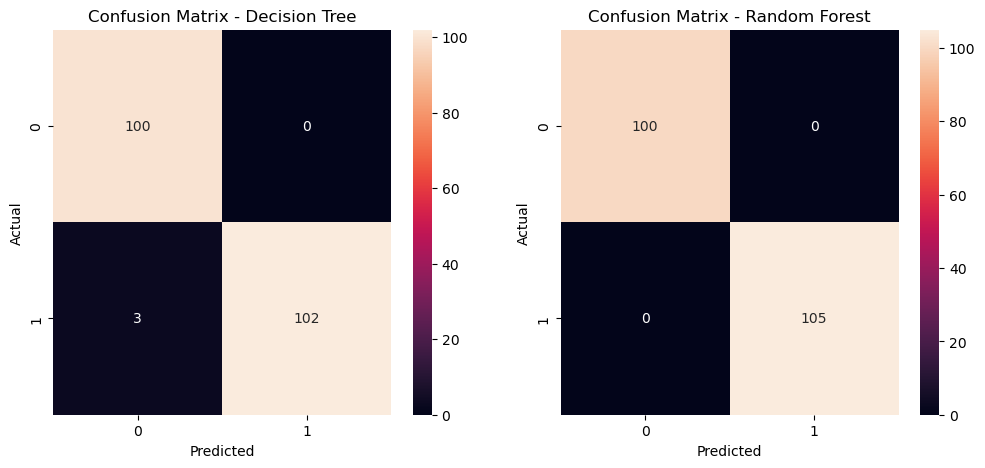

In [31]:
# Confusion Matrices
cm_dt = confusion_matrix(y_test, best_dt.predict(X_test))
cm_rf = confusion_matrix(y_test, best_rf.predict(X_test))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_dt, annot=True, fmt='d')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

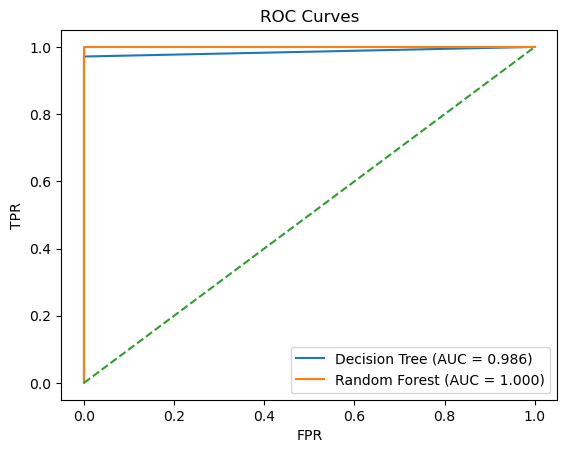

In [33]:
# ROC Curves
if len(np.unique(y)) == 2:
    fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt.predict_proba(X_test)[:, 1])
    fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
    auc_dt = roc_auc_score(y_test, best_dt.predict_proba(X_test)[:, 1])
    auc_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

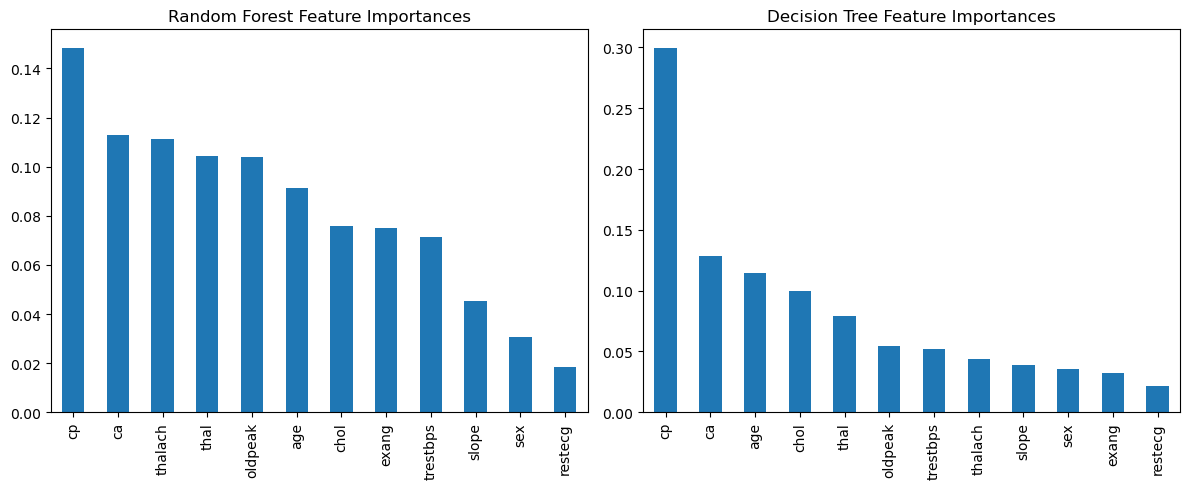


Top features by Random Forest:
cp          0.148501
ca          0.112857
thalach     0.111074
thal        0.104263
oldpeak     0.104091
age         0.091209
chol        0.075798
exang       0.075113
trestbps    0.071524
slope       0.045114
dtype: float64


In [35]:
# Feature Importance
fi_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
fi_dt = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fi_rf.head(12).plot(kind='bar')
plt.title('Random Forest Feature Importances')

plt.subplot(1,2,2)
fi_dt.head(12).plot(kind='bar')
plt.title('Decision Tree Feature Importances')

plt.tight_layout()
plt.show()

print('\nTop features by Random Forest:')
print(fi_rf.head(10))

In [37]:
# Cross Validation Scores
cv_scores_dt = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy', n_jobs=-1)
cv_scores_rf = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print('Decision Tree CV scores:', cv_scores_dt)
print('Decision Tree CV mean:', cv_scores_dt.mean())
print('\nRandom Forest CV scores:', cv_scores_rf)
print('Random Forest CV mean:', cv_scores_rf.mean())

Decision Tree CV scores: [1. 1. 1. 1. 1.]
Decision Tree CV mean: 1.0

Random Forest CV scores: [1.         1.         1.         1.         0.98536585]
Random Forest CV mean: 0.9970731707317073
